## Exploratory Data Analysis

### Import Data

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline  
pd.options.display.max_columns = None

The optimized dataset after data wrangling was stored as a pickled file. 

In [42]:
df = pd.read_pickle('project_donation_optimized.pkl')

### Exploratory Data Analysis

The exploratory data analysis provides an in-depth analysis of the DonorsChoose dataset. It provides insights from different perspectives including donations, projects, and how the userbase grew over time. To make the analysis more relevant to the US market, we will only look at donations that happened in US. 

In [43]:
## get US dataset by mapping the states
xl = pd.ExcelFile('state_long_lat.xlsx')
lon_lat_map = xl.parse('state_long_lat')
us_states = lon_lat_map['State_Short']
df_us = df[(df['donor_state'].notnull()) & (df['donor_state'].isin(us_states))]

### Donors & Donations

To start with, we will run some general numbers from the dataset including total number of donors and donations to see how many donors are actively using the website to make contributions. 

In [44]:
## total number of donors
donor_number = df_us['_donor_acctid'].nunique()
total_donation = df_us['donation_total'].sum()
print("As of October 2016, there are " + 
      str(donor_number) + 
      """ registered donors on DonorsChoose, who have made a total contribution of """ + 
      str(total_donation) + " dollars.")

As of October 2016, there are 1786756 registered donors on DonorsChoose, who have made a total contribution of 362873020.0 dollars.


Next, I would love to see among all the users, how many are frequent versus single-time donors. 

In [45]:
donation_count = df_us.groupby('_donor_acctid').size().to_frame().reset_index()
donation_count.columns = ['donor_id', 'donation_count']
#donation_count.head()
donation_freq = donation_count['donation_count'].value_counts(ascending=False).to_frame().reset_index()
donation_freq.columns = ['donation_frequency', 'count']
donation_freq.head()

,donation_frequency,count
0,1,1318268
1,2,250701
2,3,85637
3,4,40662
4,5,23093


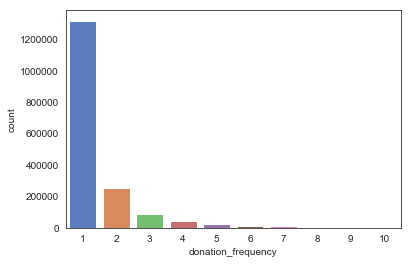

In [46]:
sns.barplot(x='donation_frequency', y='count', data=donation_freq.head(10))

Out of the 1786756 donors, majority (1318268) of them have only donated once, and only 26% are frequent donors. 

In [47]:
big_donor = donation_count[donation_count['donation_count']>=100]
big_donor['donor_id'].count()

1997

There are 1997 donors who have donated more than 100 times. I will categorize them into the big_donor category for future analysis.

### Donation Distribution

It is interesting to see how different states are using the service and where the donations are concentrated. This can be reflected in both the number of donations and total donation amount in each state. 

In [48]:
donor_state_count = df_us.groupby(df_us['donor_state'].astype('object')).size().sort_values(ascending=False)
max_donor_state = donor_state_count.head(10)
min_donor_state = donor_state_count.tail(10)

In [49]:
state_don_amt = df_us.groupby(df_us['donor_state'].astype('object'))['donation_total'].sum().sort_values(ascending=False)
max_state_amt = state_don_amt.head(10)
min_state_amt = state_don_amt.tail(10)

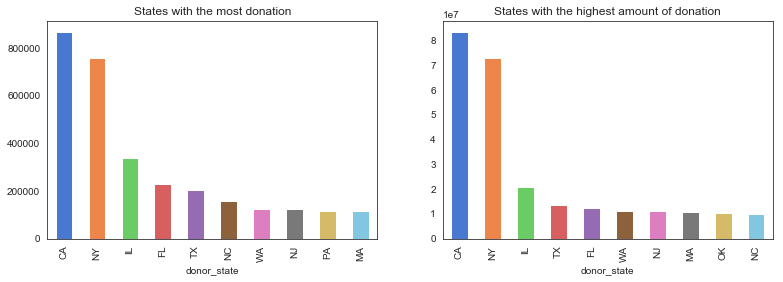

In [50]:
### states with the most donation
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
sns.set_style('white')
sns.set_palette('muted')
ax0.set_title('States with the most donation')
ax1.set_title('States with the highest amount of donation')
max_donor_state.plot.bar(ax=ax0)
max_state_amt.plot.bar(ax=ax1)

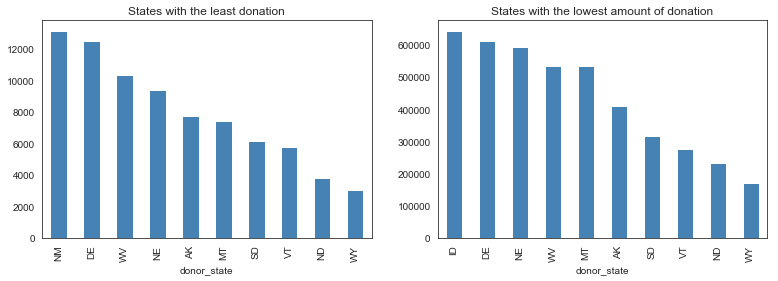

In [51]:
### states with the least donation
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
sns.set_style('white')
ax0.set_title('States with the least donation')
ax1.set_title('States with the lowest amount of donation')
min_donor_state.plot.bar(ax=ax0, color='steelblue')
min_state_amt.plot.bar(ax=ax1, color='steelblue')

The top states in the above chart are the states with the biggest population. I suspect that there is a positive correlation between number of donations and state population. I will add the population data which includes the population of each states as of 2016.   
Population data: https://www2.census.gov/programs-surveys/popest/datasets/2010-2017/state/asrh/

In [52]:
## get US population data
state_map = dict(zip(lon_lat_map['State'], lon_lat_map['State_Short']))
pop_df = pd.read_csv('population_data.csv')
pop_2016 = pop_df[['NAME', 'POPESTIMATE2016']]
pop_2016 = pop_2016.loc[5:55]
pop_2016 = pop_2016[pop_2016['NAME']!='District of Columbia']
pop_2016.columns = ['State', '2016_Population']
pop_2016['State_Short'] = pop_2016['State'].map(state_map)
pop_map = dict(zip(pop_2016['State_Short'], pop_2016['2016_Population']))
#pop_2016.head()

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Leo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Leo\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


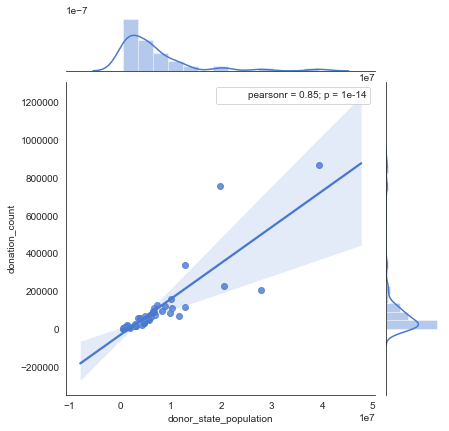

In [53]:
df_us['donor_state_population'] = df_us['donor_state'].map(pop_map)
don_pop = df_us.groupby(['donor_state', 'donor_state_population'])['donor_state'].size()
don_pop = don_pop.to_frame()
don_pop.columns = ['donation_count']
don_pop = don_pop.reset_index()

g = sns.jointplot('donor_state_population', 'donation_count', data=don_pop, kind='reg')
g.annotate(stats.pearsonr)

As seen above, there is a strong positive correlation between the state population and the number of donations from the state with a pearson correlation r equals 0.85. The small p-value suggests the strong evidence that the correlation is different than 0. Therefore, we can conclude that more donations are collected from states with a larger population.

Since we know that the population is associated with the number of donations, it would be more accurate if we compare the donation-population ratio within the state instead of total number of donations. We would add a donation_ratio column and investigate if there's any difference between different states.

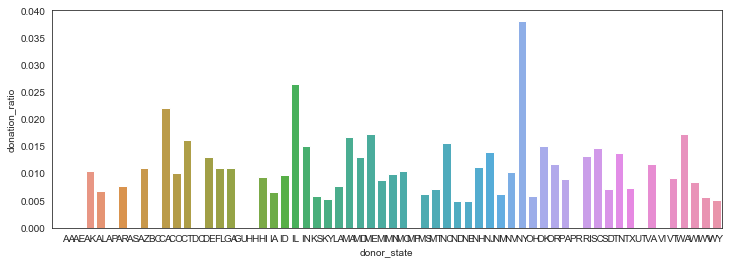

In [54]:
don_pop['donation_ratio'] = don_pop['donation_count']/don_pop['donor_state_population']
plt.figure(figsize=(12,4))
sns.barplot(x='donor_state', y='donation_ratio', data=don_pop)

In [55]:
don_pop[don_pop['donation_ratio']>=0.02]

,donor_state,donor_state_population,donation_count,donation_ratio
4,CA,39296476.0,869925,0.022137
13,IL,12835726.0,339851,0.026477
33,NY,19836286.0,757193,0.038172


We can still see different donation ratio from the above chart. In fact, New York, Illinois, and California are the top 3 states with the highest percentage of donations.

### Projects

In [56]:
print(df_us['_projectid'].nunique())
print(df_us['date_posted'].max())

924255
2016-10-11 00:00:00


As of October 2016, there are in total 924,255 projects posted on the website. In order to see how the number of projects has grown over time, we will break the numbers down into different years. We also notice that for the projects posted on the platform, they can either be completed or expired without enough donation. We would also like to see the trends in fully-funded projects. 

In [57]:
df_us['project_year'] = df_us['date_posted'].dt.year
df_us['complete_year'] = df_us['date_completed'].dt.year

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [58]:
### projects posted over time
project_over_time = df_us.groupby('project_year')['_projectid'].nunique()
completed_projects = df_us[df_us['funding_status']=='completed']
completed_over_time = completed_projects.groupby('complete_year')['_projectid'].nunique()

Text(0.5, 1.0, 'Number of total and completed projects')

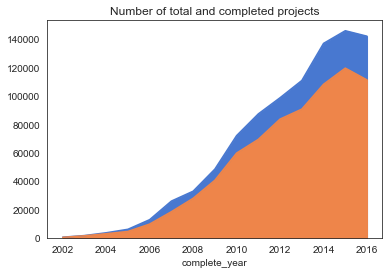

In [59]:
sns.set_style('white')
fig, ax = plt.subplots()
project_over_time.plot.area(ax=ax)
completed_over_time.plot.area(ax=ax)
ax.set_title('Number of total and completed projects')

We can see that the project flow started to pick up in a fast pace starting around year 2006. A quick research on the company's Wikipedia page unfolds that the organization has been given Charity Navigator's highest rating every year since 2005. This corresponds to the high growth path revealed in the chart.  

Now we have an idea of the project volume, let's take a look at the donation amount associated with each project. We will identify the projects with the most donation count, highest donation amount, and the average donation of all the completed projects. 

In [60]:
## project donation size
total_donation_per_project = completed_projects.groupby('_projectid')['donation_total'].sum()
total_donation_per_project = total_donation_per_project.sort_values(ascending=False)
average_donation = total_donation_per_project.mean()
average_donation

457.025634765625

In [61]:
## max donation size
print('highest donation amount: ' + str(total_donation_per_project.max()))
print('max number of donation: ' + str(completed_projects['num_donors'].max()))

highest donation amount: 186951.77
max number of donation: 848


In [62]:
print(total_donation_per_project.sort_values(ascending=False).head(1))

_projectid
bbbc6cccccd3c1bc8c44ec494bb6cf23    186951.765625
Name: donation_total, dtype: float32


In [63]:
completed_projects[completed_projects['_projectid']=='bbbc6cccccd3c1bc8c44ec494bb6cf23'].head(2)

,_donationid,_projectid,_donor_acctid,donor_city,donor_state,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,payment_method,is_teacher_referred,thank_you_packet_mailed,_teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,donor_state_population,project_year,complete_year
254134,01d72050cfc5714eb5f9bde7f2a1e2f0,bbbc6cccccd3c1bc8c44ec494bb6cf23,4242433cbedd23bf0f4f3ff22eb17ccc,NaN,OR,0,2015-12-03 14:04:45.633,425.00,75.00,500.0,paypal,0,f,ba835ad62be9d5f38b2e54a8edbf83fb,NaN,40.839062,-73.900124,New York City,NY,10457.0,urban,New York Dept Of Education,Bronx,Mr.,Gym & Fitness,Health & Sports,NaN,NaN,Supplies,highest poverty,Grades 3-5,217377.015625,255737.671875,999.0,249253.3125,313,t,f,completed,2015-08-28,2015-12-28,NaT,2016-01-29,4085989.0,2015,2015.0
254136,01dd0a7985b986793d9d6ae6204023b0,bbbc6cccccd3c1bc8c44ec494bb6cf23,0e210f62f3f0cb27598664a7f0116b09,NaN,NY,0,2015-12-01 23:38:29.281,21.25,3.75,25.0,creditcard,0,f,ba835ad62be9d5f38b2e54a8edbf83fb,NaN,40.839062,-73.900124,New York City,NY,10457.0,urban,New York Dept Of Education,Bronx,Mr.,Gym & Fitness,Health & Sports,NaN,NaN,Supplies,highest poverty,Grades 3-5,217377.015625,255737.671875,999.0,249253.3125,313,t,f,completed,2015-08-28,2015-12-28,NaT,2016-01-29,19836286.0,2015,2015.0


In [64]:
completed_projects[completed_projects['num_donors']==848]
completed_projects[completed_projects['_projectid']=='c34218abf3fecd36be01305d67ed7fbb'].head(2)

,_donationid,_projectid,_donor_acctid,donor_city,donor_state,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,payment_method,is_teacher_referred,thank_you_packet_mailed,_teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,donor_state_population,project_year,complete_year
17863,0009d2759ff78b89a8b85b95ffc1e921,c34218abf3fecd36be01305d67ed7fbb,9437d67acc13a0643c8667c019602b9d,NaN,CA,0,2015-05-29 01:04:07.193,84.150002,14.85,99.0,creditcard,1,f,7fe6dd0c1af5f911e9bc38030cfb4ced,6.112201e+10,38.006054,-122.552521,San Rafael,CA,94903.0,suburban,Dixie School District,Marin,Ms.,Health & Wellness,Health & Sports,Literacy,Literacy & Language,Supplies,moderate poverty,Grades 3-5,93563.90625,110075.1875,350.0,109333.476562,848,f,f,completed,2015-05-26,2015-08-12,2015-12-21,2015-10-24,39296476.0,2015,2015.0
17864,0019498f1881b4ab7462e92a08df5c14,c34218abf3fecd36be01305d67ed7fbb,306961a477a046e184d4e708f718111f,NaN,PA,0,2015-06-25 08:53:17.245,40.000000,0.00,40.0,creditcard,1,f,7fe6dd0c1af5f911e9bc38030cfb4ced,6.112201e+10,38.006054,-122.552521,San Rafael,CA,94903.0,suburban,Dixie School District,Marin,Ms.,Health & Wellness,Health & Sports,Literacy,Literacy & Language,Supplies,moderate poverty,Grades 3-5,93563.90625,110075.1875,350.0,109333.476562,848,f,f,completed,2015-05-26,2015-08-12,2015-12-21,2015-10-24,12787085.0,2015,2015.0


The average donations per project is around USD 450. The project with the higest donation amount is a project completed in 2015. It was posted by a teacher in New York City to raise funds for gyms and fitness purpose. The project was sponsored by 313 donors with a total donation amount of USD 186,951.77. The project with the most number of donors is a project for an elementary school in San Rafael, CA. The funds are used to support Literacy development and raised USD 93,563.91 dollars from 848 donors.

With the drastic growth in number of posted projects, it would important to keep the turnaround. I am curious to know whether it's taking longer or shorter for each project to be completed. 

In [65]:
### average time for projects to be completed
df_complete = df_us[df_us['funding_status']=='completed']
df_complete['days_to_complete'] = (df_complete['date_completed']-df_complete['date_posted']).dt.days
df_complete= df_complete[['_projectid', 'project_year', 'days_to_complete']].drop_duplicates()

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
#df_complete.head()
df_complete_nan = df_complete.dropna()

In [67]:
average_completion_days = df_complete.groupby('project_year')['days_to_complete'].mean()
#average_completion_days.values

C:\Users\Leo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


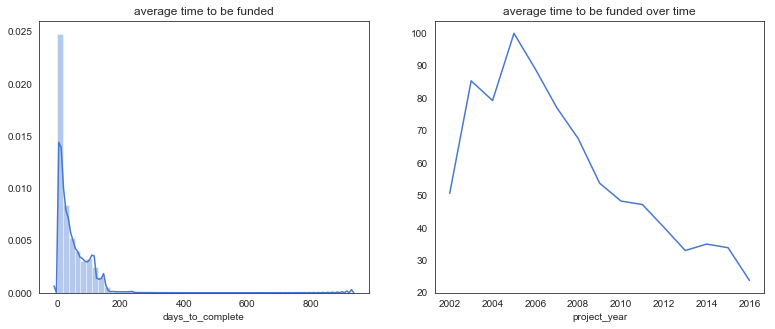

In [68]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
sns.set_style('white')
ax0.set_title('average time to be funded')
ax1.set_title('average time to be funded over time')
sns.distplot(df_complete_nan['days_to_complete'], ax = ax0)
sns.lineplot(x=average_completion_days.index, y=average_completion_days.values, ax = ax1)

Majority of the projects are fully-donated within 100 days, and the turnaround keeps decreasing with more and more people start using the platform. The projects that are posted recently were completed within around a month. 

#### project completion time vs. primary focus area

In [69]:
print(df_us['primary_focus_area'].unique())

[Literacy & Language, Special Needs, Music & The Arts, Math & Science, Applied Learning, Health & Sports, History & Civics, NaN]
Categories (7, object): [Literacy & Language, Special Needs, Music & The Arts, Math & Science, Applied Learning, Health & Sports, History & Civics]


DonorsChoose placed projects into 7 different focus areas and I'm curious to see if the time periods to complete the donations are the same for different focus areas. Since the platform wasn't getting a lot of volume before 2006. The projects posted back then created many outliers in terms of completion time. For the analysis purpose, I will onlyb use the projects posted between 2006 and 2016. 

In [70]:
### average time for projects to be completed - project focus
df_complete_recent = df_us[(df_us['funding_status']=='completed') & (df_us['date_posted']>='2006-01-01')]
df_complete_recent['days_to_complete'] = (df_complete_recent['date_completed']-df_complete_recent['date_posted']).dt.days
df_complete_recent= df_complete_recent[['_projectid', 'primary_focus_area', 'days_to_complete', 'donation_total']].drop_duplicates()
mean_comp_days = df_complete_recent.groupby('primary_focus_area')['days_to_complete'].mean()
print(mean_comp_days)

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


primary_focus_area
Applied Learning       43.045365
Health & Sports        35.078756
History & Civics       41.731956
Literacy & Language    42.343375
Math & Science         40.364388
Music & The Arts       43.296106
Special Needs          43.593827
Name: days_to_complete, dtype: float64


The means look similar among different subjects. I'll do a Tukey hypothesis test to see if the means are actually the same.   
H0: the mean time it takes to complete the donation for reach subject area is the same.   
HA: there is significant difference in the mean time to complete the donation among different subject areas.  

In [71]:
df_complete_recent = df_complete_recent.dropna()
v = df_complete_recent['days_to_complete']
labels = df_complete_recent['primary_focus_area']

### Tukey
tukey_results = pairwise_tukeyhsd(v, labels, 0.05)
print(tukey_results)

           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
  Applied Learning    Health & Sports   -7.9666   -8.49  -7.4432  True 
  Applied Learning    History & Civics  -1.3134  -1.8376 -0.7892  True 
  Applied Learning  Literacy & Language  -0.702  -1.0581 -0.3458  True 
  Applied Learning     Math & Science    -2.681  -3.0514 -2.3105  True 
  Applied Learning    Music & The Arts   0.2507  -0.1726  0.6741 False 
  Applied Learning     Special Needs     0.5485   0.0872  1.0097  True 
  Health & Sports     History & Civics   6.6532   6.0807  7.2257  True 
  Health & Sports   Literacy & Language  7.2646   6.8406  7.6887  True 
  Health & Sports      Math & Science    5.2856   4.8495  5.7217  True 
  Health & Sports     Music & The Arts   8.2174   7.7355  8.6992  True 
  Health & Sports      Special Needs     8.5151   7.9996  9.0305

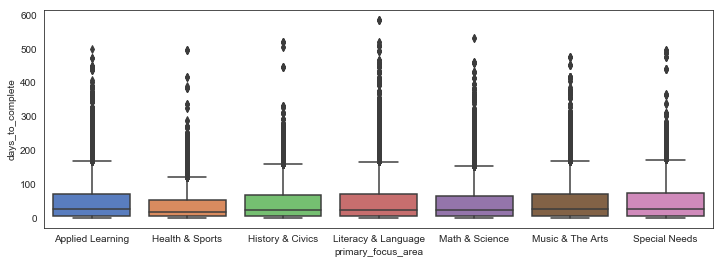

In [72]:
plt.figure(figsize=(12,4))
sns.boxplot(x='primary_focus_area', y='days_to_complete', data=df_complete_recent)

The Tukey test suggests that in most cases, we can reject the null hypothesis and the mean time to complete the donation in different subject areas are indeed different. Health & Sports has the lowest mean and the narrowest 95% confidence interval. It is the cateogry that requires the least time to collect donation.  

#### projects vs. grade levels

Is there a difference among grade levels? Are some grades require more funding than the others? 

In [73]:
projects_grade = df_us.groupby('grade_level')['_projectid'].nunique()

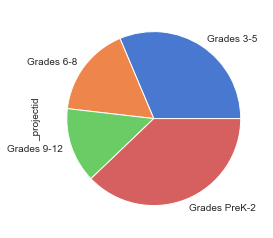

In [74]:
sns.set_style('white')
sns.set_palette('muted')
fig, ax = plt.subplots(1, 1)
ax.set_ylabel('')
projects_grade.plot(kind='pie', ax=ax)

Most of the fundings are demanded in elementary level, especially among lower grades. 

#### projects vs. poverty level

In [75]:
projects_pov = df_us.groupby('poverty_level')['_projectid'].nunique()

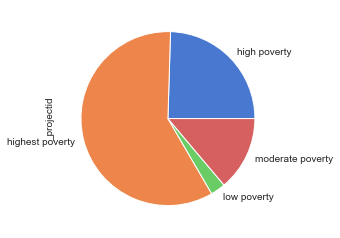

In [76]:
sns.set_style('white')
sns.set_palette('muted')
projects_pov.plot(kind='pie')

It makes sense that more donations are needed where the poverty level is high with limited government funding. 

#### projects vs. focus area

With the current trends in tech development, schools are focusing more on technology-related education such as STEM. To see if the donation request match the trend, we will divide the projects into different subject areas.

In [77]:
project_focus_area = df_us.groupby('primary_focus_area')['_projectid'].nunique().sort_values(ascending=False)

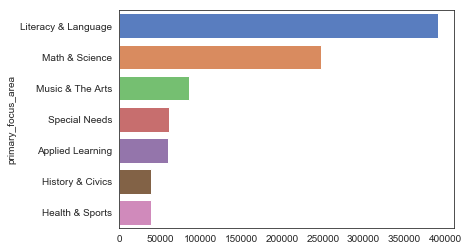

In [78]:
sns.set_palette('muted')
sns.barplot(x=project_focus_area.values, y=project_focus_area.index, order=project_focus_area.index)

Indeed, teachers are requesting more support in Literacy & Language and Math & Science categories. But was this the trend since the beginning? 

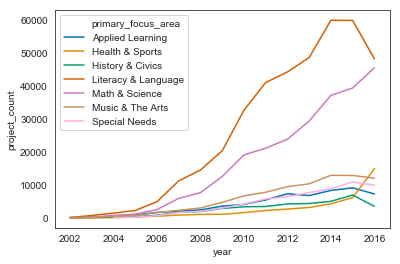

In [79]:
project_focus_area = df_us.groupby(['project_year','primary_focus_area'])['_projectid'].nunique()
project_focus_area = project_focus_area.to_frame().reset_index()
project_focus_area.columns = ['year', 'primary_focus_area', 'project_count']
sns.set_palette('colorblind')
sns.lineplot(data=project_focus_area, x='year', y='project_count', hue='primary_focus_area')

While all projects exhibit an upward trend, demand in Math & Science and Literacy & Language has grown exponentially. While most of the projects have started to slow down since 2015, projects in Math & Sicence continued to expand. Furthermore, I'm curious if the same pattern exists in all poverty levels. 

In [80]:
focus_poverty = df_us.groupby(['primary_focus_area', 'poverty_level'])['_projectid'].nunique()
focus_poverty = focus_poverty.to_frame().reset_index()
focus_poverty.head()

,primary_focus_area,poverty_level,_projectid
0,Applied Learning,high poverty,14880
1,Applied Learning,highest poverty,35671
2,Applied Learning,low poverty,1595
3,Applied Learning,moderate poverty,7892
4,Health & Sports,high poverty,9673


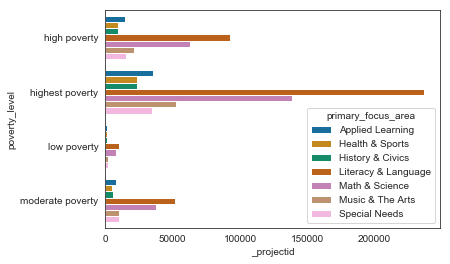

In [81]:
sns.barplot(x='_projectid', y='poverty_level', hue='primary_focus_area', data=focus_poverty)

Despite different wealth levels among schools, Literacy & Language and Math & Science are always on the top of the bucket list. 

### Teachers

The projects on the platform are teacher-driven. Let's first take a look at the total teacher population over years. 

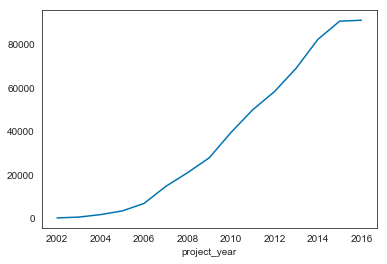

In [82]:
teacher_count = df_us.groupby('project_year')['_teacher_acctid'].nunique()
teacher_count
sns.set_style('white')
teacher_count.plot()

Teacher users have more than doubled from year 2010 to 2016. It exhibits a positive correlation with the project growth.  

Next, I would like to see how many projects are posted by female teachers vs. male teachers. 

In [83]:
df_us['teacher_gender'] = ['Female' if i in ['Mrs.', 'Ms.'] else 'Male' if i=='Mr.' else 'Unknown' for i in df_us['teacher_prefix']] 

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [84]:
## number of teachers posting projects over years
teacher_over_time = df_us.groupby(['project_year', 'teacher_gender'])['_teacher_acctid'].nunique()
teacher_over_time = teacher_over_time.to_frame().reset_index()
teacher_over_time.columns = ['year', 'teacher_gender', 'teacher_count']
#teacher_over_time

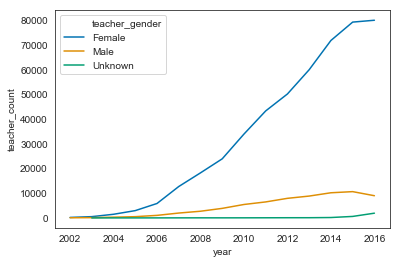

In [85]:
sns.lineplot(data=teacher_over_time, x='year', y='teacher_count', hue='teacher_gender')

We can spot that the number of male teachers grew very little and majority the projects are posted by female teachers. That's probably because female dominates the teaching industry.  

Would the teacher's gender have any influence on the success rate of the donation? Let's compare the projects posted by female teachers and male teachers to see if there is a significant difference.   

H0: there is no difference in the donation completion rate between male and female teachers   
H1: there is a significant different in the donation completion rate between male and female teachers

##### bootstrapping

In [105]:
## add a column to indicate whether the project is completed. 
df_us['project_completed'] = [1 if i=='completed' else np.nan if i=='live' else 0 for i in df_us['funding_status']]

C:\Users\Leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [118]:
unique_projects = df_us[['_projectid', 'teacher_gender', 'project_completed']].drop_duplicates()
completion_rate = unique_projects.groupby('teacher_gender')['project_completed'].mean()
female_comp_rate = completion_rate[0]
male_comp_rate = completion_rate[1]
comp_rate_diff = male_comp_rate - female_comp_rate
      
## shift projects posted by male and female teachers to have the same mean completion rate
male_project = unique_projects[unique_projects['teacher_gender']=='Male']['project_completed'].dropna()
female_project = unique_projects[unique_projects['teacher_gender']=='Female']['project_completed'].dropna()
comp_rate = np.mean(unique_projects['project_completed'])
male_shifted = male_project + (comp_rate - male_comp_rate)
female_shifted = female_project + (comp_rate - female_comp_rate)      

0.003937766006057886


In [138]:
## bootstrap 1000 samples
def draw_bs_reps(data, func, size=1):
    bs_reps = np.empty(size)
    
    for i in range(size):
        bs_samples = np.random.choice(data, len(data))
        bs_reps[i] = func(bs_samples)
    return bs_reps

bs_replicates_m = draw_bs_reps(male_shifted, np.mean, 1000)
bs_replicates_f = draw_bs_reps(female_shifted, np.mean, 1000)
bs_replicates_diff = bs_replicates_m - bs_replicates_f

p = np.sum(bs_replicates_diff >= comp_rate_diff)/len(bs_replicates_diff)
print('p-value: ', p)

p-value:  0.001


##### Chi-square Test

In [94]:
### build a chi-square contingency table
male_total = df_us[(df_us['funding_status']!='live') & (df_us['teacher_gender']=='Male')]['_projectid'].nunique()
male_complete = df_us[(df_us['funding_status']=='completed') & (df_us['teacher_gender']=='Male')]['_projectid'].nunique()
male_incomplete = male_total - male_complete
female_total = df_us[(df_us['funding_status']!='live') & (df_us['teacher_gender']=='Female')]['_projectid'].nunique()
female_complete = df_us[(df_us['funding_status']=='completed') & (df_us['teacher_gender']=='Female')]['_projectid'].nunique()
female_incomplete = female_total - female_complete

x = [[male_complete, male_incomplete], [female_complete, female_incomplete]]
print(x)

[[92002, 18311], [651946, 133464]]


In [101]:
print('donation completion rate by male teachers: ', (male_complete/male_total))
print('donation completion rate by female teachers: ', (female_complete/female_total))

donation completion rate by male teachers:  0.8340086843799008
donation completion rate by female teachers:  0.830070918373843


In [104]:
## chi-square test
chi2, pval, dof, expected = stats.chi2_contingency(x)
print('p-value: ', pval)
print(chi2)

p-value:  0.0011129774259750452
10.62950100655928


At a 0.05 significance level, the null hypothesis that female teachers and male teachers achieve the same donation completion rate can be rejected. 

### Conclusion

With the above analysis, we can observe the following: 
* Out of the massive number of donors online, only 26% has donated more than once. 
* California and New York are the two states that hosted most of the donations. These are also the two states that have the biggest population. New York, Illinois, and California are the top 3 states with the highest percentage of population that donated. 
* The project volume has grown rapidly in the past 10 years and the time to collect donation has decreased drastically. 
* Health & Sports tends to raise money quickly compared to other categories.
* Lower grades in elementary schools need the most financing support, especially in schools that are located in high-poverty regions. 
* Despite the poverty level, Literacy & Language and Math & Science are the categories that need the most funding. These two subjects have been more dominating in the recent years. 

Machine learning goals: 
* Identify the characteristics of the frequent donors and ways to motivate the others.